Training Original Mini-GPT...
Epoch 0, Loss 3.5052
Epoch 50, Loss 1.7916
Epoch 100, Loss 0.8522
Epoch 150, Loss 0.4323
Epoch 200, Loss 0.3096
Epoch 250, Loss 0.2570
Epoch 300, Loss 0.3610
Epoch 350, Loss 0.3327
Epoch 400, Loss 0.2502
Epoch 450, Loss 0.2790

Training Deep-and-Thin Mini-GPT...
Epoch 0, Loss 3.5710
Epoch 50, Loss 2.0775
Epoch 100, Loss 1.2878
Epoch 150, Loss 1.1698
Epoch 200, Loss 0.7507
Epoch 250, Loss 0.5725
Epoch 300, Loss 0.5014
Epoch 350, Loss 0.7504
Epoch 400, Loss 0.3753
Epoch 450, Loss 0.3747

Training Deep-and-Thin Mini-GPT (SwiGLU)...
Epoch 0, Loss 3.5585
Epoch 50, Loss 2.2222
Epoch 100, Loss 1.4789
Epoch 150, Loss 1.3562
Epoch 200, Loss 1.0919
Epoch 250, Loss 0.7322
Epoch 300, Loss 0.5848
Epoch 350, Loss 0.5640
Epoch 400, Loss 0.5936
Epoch 450, Loss 0.5419

===== Comparison =====
Original Mini-GPT: Val Loss=6.2918, Perplexity=540.1136, Params=104477
Deep-and-Thin GPT: Val Loss=7.1011, Perplexity=1213.2633, Params=59069
Deep-and-Thin GPT (SwiGLU): Val Loss=6.696

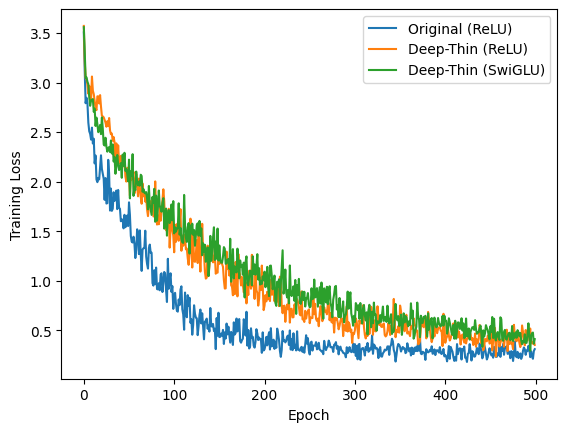


Generated by Original Mini-GPT:
 Alice she wosthe forest, discovering newts and magi stumbled upon a mysterious. One day, st, she stumbled 

Generated by Deep-and-Thin GPT:
 Alice who loved adventures. Ong girl ne . One da y, she sthe sturis. One d dage scan s s licril cre vilore

Generated by Deep-and-Thin GPT (SwiGLU):
 Alice fore discoved ag way, shere was wasmalsmbll villd vinged allivend y, youne ed the dicre was a alsmed


In [ ]:
# ================================
# Compare Mini-GPT vs Deep-and-Thin vs Deep-and-Thin (SwiGLU)
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------
# 1️⃣ Set seeds
# ------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------
# 2️⃣ Sample story dataset
# ------------------
story_text = (
    "Once upon a time, in a land far away, there was a small village. "
    "In this village, lived a young girl named Alice who loved adventures. "
    "Every day, she would explore the forest, discovering new secrets and magical creatures. "
    "One day, she stumbled upon a mysterious door hidden behind the trees."
)

chars = sorted(list(set(story_text)))
vocab_size = len(chars)
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(stoi)}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return "".join([itos[i] for i in l])

data = torch.tensor(encode(story_text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ------------------
# 3️⃣ Data loader
# ------------------
def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# ------------------
# 4️⃣ Transformer building blocks
# ------------------
class Head(nn.Module):
    def __init__(self, head_size, embedding_dim, block_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim, dropout, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, embedding_dim, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForward(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# SwiGLU Implementation
# ------------------
class SwiGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, input_dim, bias=False)

    def forward(self, x):
        return self.v(self.w1(x) * torch.sigmoid(self.w2(x)))

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        hidden_dim = embedding_dim * 4
        self.net = nn.Sequential(
            SwiGLU(embedding_dim, hidden_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class BlockSwiGLU(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForwardSwiGLU(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# 5️⃣ GPT Classes
# ------------------
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

class MiniGPTSwiGLU(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.blocks = nn.Sequential(*[
            BlockSwiGLU(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)
        ])

# ------------------
# 6️⃣ Training helper
# ------------------
def train_model(model_class, config, train_data, val_data, epochs=200):
    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        block_size=config['block_size'],
        dropout=config['dropout']
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    train_losses = []
    for epoch in range(epochs):
        xb, yb = get_batch(train_data, config['batch_size'], config['block_size'])
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.4f}")
    # Validation
    xb, yb = get_batch(val_data, config['batch_size'], config['block_size'])
    with torch.no_grad():
        _, val_loss = model(xb, yb)
    perplexity = torch.exp(val_loss).item()
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model, train_losses, val_loss.item(), perplexity, param_count

# ------------------
# 7️⃣ Configs
# ------------------
block_size = 16
dropout = 0.1
batch_size = 8
lr = 1e-2
epochs = 500

original_config = {
    'embedding_dim': 64,
    'n_layers': 2,
    'n_heads': 4,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

deepthin_config = {
    'embedding_dim': 24,
    'n_layers': 8,
    'n_heads': 2,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

# ------------------
# 8️⃣ Train models
# ------------------
print("Training Original Mini-GPT...")
orig_model, orig_losses, orig_val_loss, orig_ppl, orig_params = train_model(MiniGPT, original_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT...")
deep_model, deep_losses, deep_val_loss, deep_ppl, deep_params = train_model(MiniGPT, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT (SwiGLU)...")
deep_swiglu_model, deep_swiglu_losses, deep_swiglu_val_loss, deep_swiglu_ppl, deep_swiglu_params = train_model(MiniGPTSwiGLU, deepthin_config, train_data, val_data, epochs)

# ------------------
# 9️⃣ Compare metrics
# ------------------
print("\n===== Comparison =====")
print(f"Original Mini-GPT: Val Loss={orig_val_loss:.4f}, Perplexity={orig_ppl:.4f}, Params={orig_params}")
print(f"Deep-and-Thin GPT: Val Loss={deep_val_loss:.4f}, Perplexity={deep_ppl:.4f}, Params={deep_params}")
print(f"Deep-and-Thin GPT (SwiGLU): Val Loss={deep_swiglu_val_loss:.4f}, Perplexity={deep_swiglu_ppl:.4f}, Params={deep_swiglu_params}")

# Plot training curves
plt.plot(orig_losses, label='Original (ReLU)')
plt.plot(deep_losses, label='Deep-Thin (ReLU)')
plt.plot(deep_swiglu_losses, label='Deep-Thin (SwiGLU)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# ------------------
# 10️⃣ Generate story continuation
# ------------------
prompt = "Alice "
context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

gen_orig = orig_model.generate(context, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode(gen_swiglu))


=== Mini-GPT Comparison Report ===

Model: Original Mini-GPT
  Parameters: 104477
  Validation Loss: 6.2918
  Perplexity: 540.1136
  Contains SwiGLU? False
  Generated Text:
    Alice who loved adventures. Every day, who st, sthere Every day, she would explore the forest,rets and mag

--------------------------------------------------------------------------------
Model: Deep-and-Thin (ReLU)
  Parameters: 59069
  Validation Loss: 7.1011
  Perplexity: 1213.2633
  Contains SwiGLU? False
  Generated Text:
    Alice loved adveng fnt, s seris a avilllllaged Ind m fsthis vilagove, lived stupon a mewa a s metumbl ed u

--------------------------------------------------------------------------------
Model: Deep-and-Thin (SwiGLU)
  Parameters: 76541
  Validation Loss: 6.6968
  Perplexity: 809.8483
  Contains SwiGLU? True
  Generated Text:
    Alice Alice upon a gicreaw ys shere wa, a small Ivillage, ved und young gecre d gicreatures. One day, she 

----------------------------------------------

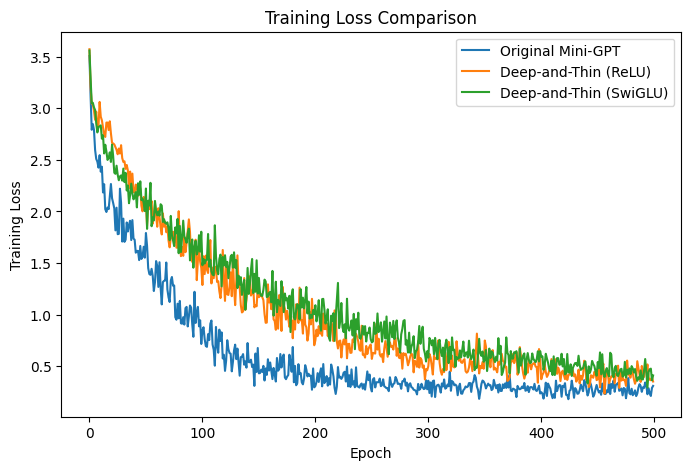

In [ ]:
# ================================
# Full Comparison Report
# ================================

models = {
    "Original Mini-GPT": orig_model,
    "Deep-and-Thin (ReLU)": deep_model,
    "Deep-and-Thin (SwiGLU)": deep_swiglu_model
}

val_losses = {
    "Original Mini-GPT": orig_val_loss,
    "Deep-and-Thin (ReLU)": deep_val_loss,
    "Deep-and-Thin (SwiGLU)": deep_swiglu_val_loss
}

perplexities = {
    "Original Mini-GPT": orig_ppl,
    "Deep-and-Thin (ReLU)": deep_ppl,
    "Deep-and-Thin (SwiGLU)": deep_swiglu_ppl
}

params = {
    "Original Mini-GPT": orig_params,
    "Deep-and-Thin (ReLU)": deep_params,
    "Deep-and-Thin (SwiGLU)": deep_swiglu_params
}

# Function to check if SwiGLU exists in model
def contains_swiglu(model):
    return any(isinstance(m, SwiGLU) for m in model.modules())

# Generate outputs for the same prompt
prompt = "Alice "
context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

generated_texts = {}
for name, model in models.items():
    gen = model.generate(context, max_new_tokens=100)[0].tolist()
    generated_texts[name] = decode(gen)

# Print side-by-side report
print("=== Mini-GPT Comparison Report ===\n")
for name in models:
    print(f"Model: {name}")
    print(f"  Parameters: {params[name]}")
    print(f"  Validation Loss: {val_losses[name]:.4f}")
    print(f"  Perplexity: {perplexities[name]:.4f}")
    print(f"  Contains SwiGLU? {contains_swiglu(models[name])}")
    print(f"  Generated Text:\n    {generated_texts[name]}\n")
    print("-"*80)

# Optional: Plot all training losses together if available
plt.figure(figsize=(8,5))
plt.plot(orig_losses, label='Original Mini-GPT')
plt.plot(deep_losses, label='Deep-and-Thin (ReLU)')
plt.plot(deep_swiglu_losses, label='Deep-and-Thin (SwiGLU)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
